In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import r2_score
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# 3 Questions
## 1) What are the key drivers of price? 
It should be very interesting to understand the key things that drive a higher price for an Air BnB in Seattle. We are slightly missing one piece of which is the number of bookings, but by making an assumption that people have evaluated their listing relative to comparable listings we should be able to model price reasonably well and extract some interesting relationships. Understanding this relationship will allow AirBnB to advertise a reasonable price to new listers as well as alert listers when they might be charging an unreasonable price which may be affecting their ability to book their property.
## 2) What is the relationship between supply and demand?
Based on the listings dataset I am interestd to understand how both availability and price change throughout the week and year. Once again we are missing some representation of the number of times that a property is booked, but with a similar assumption as above we can likely still get pretty close.
## 3) What do people talk about in their reviews?
I would love to answer the question, what results in people giving positive reviews, however, since we are without labels and at a quick glance the reviews are overwhelmingly positive, I am afraid that may not in fact provide too much insight without an incredible amount of effort. So, I will instead do an analysis of the topics covered in the reviews.

In [2]:
cal = pd.read_csv('seattle/calendar.csv')
lis = pd.read_csv('seattle/listings.csv')
rev = pd.read_csv('seattle/reviews.csv')

In [257]:
rev.shape

(84849, 6)

In [258]:
rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [296]:
rev.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [15]:
cal.shape

(1393570, 4)

In [298]:
cal.head(10)

,listing_id,date,available,price,price_num,avail_flag,dow,id,neighbourhood_group_cleansed
0,241032,2016-01-04,t,$85.00,85.0,1,Monday,241032,Queen Anne
1,241032,2016-01-05,t,$85.00,85.0,1,Tuesday,241032,Queen Anne
2,241032,2016-01-06,f,NaN,NaN,0,Wednesday,241032,Queen Anne
3,241032,2016-01-07,f,NaN,NaN,0,Thursday,241032,Queen Anne
4,241032,2016-01-08,f,NaN,NaN,0,Friday,241032,Queen Anne
5,241032,2016-01-09,f,NaN,NaN,0,Saturday,241032,Queen Anne
6,241032,2016-01-10,f,NaN,NaN,0,Sunday,241032,Queen Anne
7,241032,2016-01-11,f,NaN,NaN,0,Monday,241032,Queen Anne
8,241032,2016-01-12,f,NaN,NaN,0,Tuesday,241032,Queen Anne
9,241032,2016-01-13,t,$85.00,85.0,1,Wednesday,241032,Queen Anne


In [279]:
for col in lis.columns:
    print('col : {0}'.format(col))
    print('desc: {0}'.format(lis.loc[0, col]))

col : id
desc: 241032
col : listing_url
desc: https://www.airbnb.com/rooms/241032
col : scrape_id
desc: 20160104002432
col : last_scraped
desc: 2016-01-04
col : name
desc: Stylish Queen Anne Apartment
col : summary
desc: nan
col : space
desc: Make your self at home in this charming one-bedroom apartment, centrally-located on the west side of Queen Anne hill.   This elegantly-decorated, completely private apartment (bottom unit of a duplex) has an open floor plan, bamboo floors, a fully equipped kitchen, a TV,  DVD player, basic cable, and a very cozy bedroom with a queen-size bed. The unit sleeps up to four (two in the bedroom and two on the very comfortable fold out couch, linens included) and includes free WiFi and laundry. The apartment opens onto a private deck, complete with it's own BBQ, overlooking a garden and a forest of black bamboo.    The Apartment is perfectly-located just one block from the bus lines where you can catch a bus and be downtown Seattle in fifteen minutes or 

# Predict Price
it would be valuable to airbnb as well as listing owners to know the key dimensions required to command the maximum value for their listing as well as to know the proper price to present in order to be competitive

## Methodology
the first piece of information that will surely differentiate price of a listing is the location, within location surely the other dimensions (# of rooms, # of bedrooms) will determine price. This very naturally falls inside of a mixed effects modeling approach. We should be careful to decide which level of neighbourhood we use. We could utilize the neighbourhood level in the mixed effects modeling, or we could use the neighbourhood group level. The trade-off is granularity for sample size.

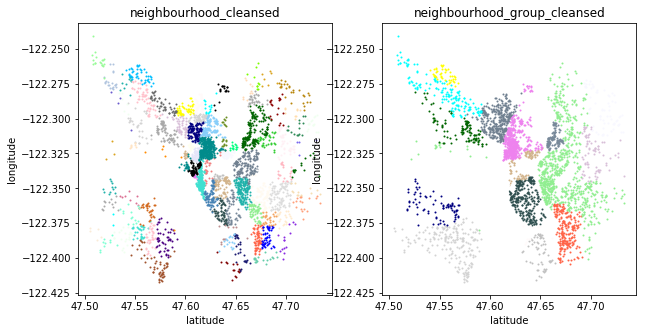

In [136]:
fig = plt.figure()
fig.set_size_inches(10, 5)
col_list = ['neighbourhood_cleansed', 'neighbourhood_group_cleansed']
ax_dict = dict(zip(col_list, [plt.subplot(121), plt.subplot(122)]))

for col in col_list:
    np.random.seed(1)

    c_dict = dict(zip(lis[col].unique(),\
                      np.random.choice(list(mcolors.CSS4_COLORS.keys()), size = len(lis[col].unique()))))
    for neigh in lis[col].unique():
        lis.loc[lis[col] == neigh].plot(kind = 'scatter', x = 'latitude', y = 'longitude', color = c_dict[neigh],\
                                        ax = ax_dict[col], s = 1.0, title = col)

## Data Preparation

In [ ]:
set_val = set([])

for idx in range(len(lis)):
    set_val = set_val.union(set(lis.loc[idx, 'amenities'].replace('"','').strip('{').strip('}').split(',')))
    
set_val = set_val - set([''])
print(set_val)

amen_list = []

for amen in set_val:
    amen_clean = amen.lower().replace(' ', '_').replace('/','_').replace('-','_').replace('(', '').replace(')','')
    amen_clean = amen_clean.replace('24_', 'twofour')
    print(amen_clean)
    lis[amen_clean] = lis.apply(lambda row: int(amen in row['amenities']), axis = 1)
    amen_list.append(amen_clean)

In [194]:
lis['price_num'] = lis.apply(lambda row: float(row['price'].strip('$').replace(',','')), axis = 1)

In [303]:
num_list = ['accommodates','bathrooms', 'beds', 'guests_included', 'availability_30'] + amen_list
eq_str = ''
for col in num_list:
    lis[col].fillna(lis[col].median(), inplace = True)
    eq_str += ' {0} +'.format(col)

cat_list = ['room_type', 'property_type', 'instant_bookable', 'host_identity_verified']

for cat in cat_list:
    lis[cat].fillna(lis[cat].mode()[0], inplace = True)
    eq_str += ' C({0}) +'.format(cat)

eq_str = eq_str.strip(' + ')

print(eq_str)

accommodates + bathrooms + beds + guests_included + availability_30 + iron + kitchen + elevator_in_building + other_pets + dogs + pets_allowed + wheelchair_accessible + tv + safety_card + smoking_allowed + washer + fire_extinguisher + breakfast + hangers + pets_live_on_this_property + internet + family_kid_friendly + heating + shampoo + pool + carbon_monoxide_detector + laptop_friendly_workspace + lock_on_bedroom_door + twofourhour_check_in + indoor_fireplace + first_aid_kit + hair_dryer + free_parking_on_premises + suitable_for_events + doorman + smoke_detector + gym + dryer + wireless_internet + air_conditioning + cable_tv + cats + washer___dryer + essentials + buzzer_wireless_intercom + hot_tub + C(room_type) + C(property_type) + C(instant_bookable) + C(host_identity_verified)


## Model Fit

In [304]:
md = smf.mixedlm('price_num ~ {0}'.format(eq_str), lis, groups=lis['neighbourhood_group_cleansed'])
mdf = md.fit()

rm_col = []
for col, p in mdf.pvalues.items():
    if p > 0.05 and 'C(' not in col:
        print('remove {0}'.format(col))
        eq_str = eq_str.replace('+ {0} '.format(col), '')    

md = smf.mixedlm('price_num ~ {0}'.format(eq_str), lis, groups=lis['neighbourhood_group_cleansed'])
mdf = md.fit()
print(mdf.summary())
lis['price_pred'] = mdf.predict()
print('r2 = {0:.3f}'.format(r2_score(lis['price_num'], lis['price_pred'])))

C:\Users\awz529\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\awz529\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\awz529\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\awz529\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\awz529\AppData\Local\Continuum\anaconda3\lib\site-packages\stat

remove iron
remove kitchen
remove other_pets
remove dogs
remove pets_allowed
remove wheelchair_accessible
remove tv
remove safety_card
remove smoking_allowed
remove washer
remove fire_extinguisher
remove breakfast
remove pets_live_on_this_property
remove family_kid_friendly
remove heating
remove shampoo
remove pool
remove carbon_monoxide_detector
remove laptop_friendly_workspace
remove lock_on_bedroom_door
remove twofourhour_check_in
remove first_aid_kit
remove hair_dryer
remove free_parking_on_premises
remove suitable_for_events
remove smoke_detector
remove gym
remove dryer
remove cats
remove washer___dryer
remove buzzer_wireless_intercom


C:\Users\awz529\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\awz529\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\awz529\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\awz529\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          price_num  
No. Observations:           3818             Method:                      REML       
No. Groups:                 17               Scale:                       3608.4904  
Min. group size:            11               Likelihood:                  -20967.3925
Max. group size:            794              Converged:                   No         
Mean group size:            224.6                                                    
-------------------------------------------------------------------------------------
                                     Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------------------------------
Intercept                             25.885    7.828   3.307 0.001   10.543   41.227
C(room_type)[T.Private room]         -37.609    2.797 -13.448 0.000  -43.090  

C:\Users\awz529\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\awz529\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)


# Price By Date
the second interesting thing that I would like to investigate is price variance by date. Since we have a base prediction from the last analysis we could predicte price by listing and look at the seasonal variance from this base price prediction.<br>

we also need to know if there is anything wierd about the availability that artificually causes this seasonality

In [219]:
cal.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


## Prepare Data

In [ ]:
def price_2_flt(price):
    try:
        return float(price)
    except:
        return float(price.strip('$').replace(',',''))

cal['price_num'] = cal.apply(lambda row: price_2_flt(row['price']) , axis = 1)

cal['date'] = pd.to_datetime(cal['date'])

cal['avail_flag'] = cal['available'].map({'t': 1, 'f': 0})

cal['dow'] = cal['date'].dt.day_name()

cal = cal.merge(lis[['id', 'neighbourhood_group_cleansed']], how = 'left', left_on = 'listing_id', right_on = 'id')

## Supply and Demand
It is a bit surprising that there is not more of a spike in price with the step changes downward in supply

Text(0.5, 1.0, 'Units Available')

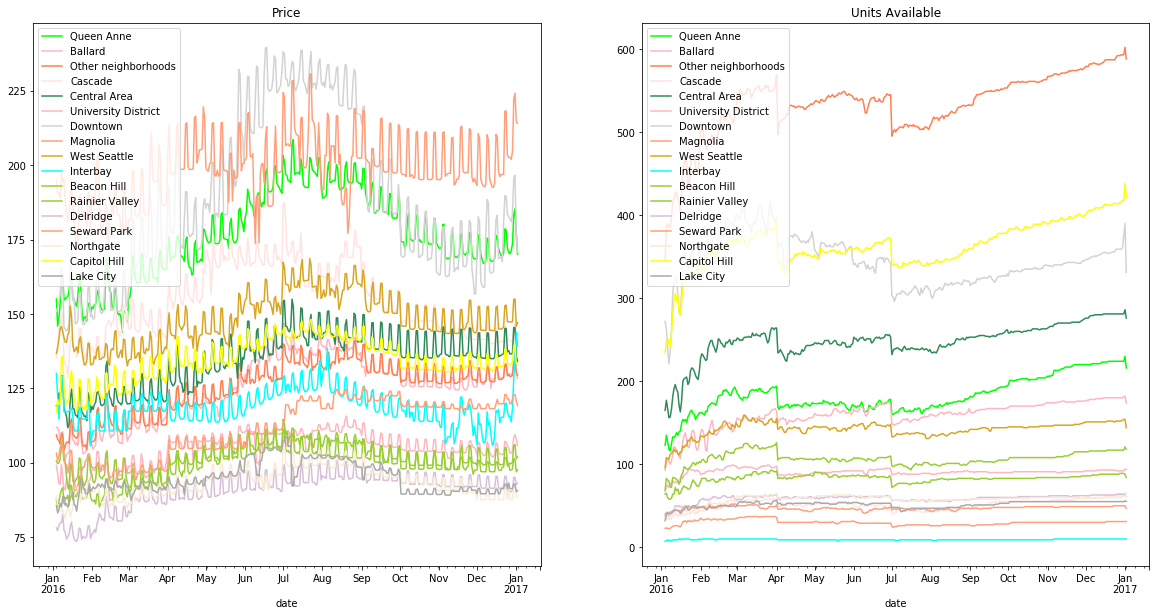

In [294]:
np.random.seed(13)
fig = plt.figure()
fig.set_size_inches(20, 10)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
c_dict = dict(zip(cal['neighbourhood_group_cleansed'].unique(),\
                  np.random.choice(list(mcolors.CSS4_COLORS.keys()),\
                                   size = len(lis['neighbourhood_group_cleansed'].unique()))))

for neigh in cal['neighbourhood_group_cleansed'].unique():
    use_df = cal.loc[cal['neighbourhood_group_cleansed'] == neigh]

    dt_prc = use_df.groupby(['date'])['price_num'].mean().reset_index()
    dt_prc.plot(kind = 'line', x = 'date', y = 'price_num', ax = ax1, label = neigh, color = c_dict[neigh])

    avail = use_df.groupby(['date'])['avail_flag'].sum().reset_index()
    avail.plot(kind = 'line', x = 'date',y = 'avail_flag', ax = ax2, label = neigh, color = c_dict[neigh])
    
ax1.set_title('Price')
ax2.set_title('Units Available')

## Supply and Demand By Day of Week
It is interesting to me that there is not variability in availability by day of week.

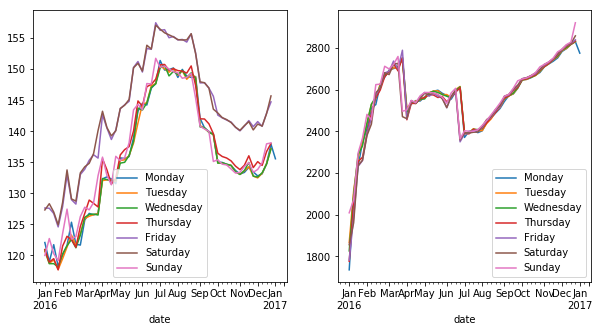

In [295]:
fig = plt.figure()
fig.set_size_inches(10, 5)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for dow in cal['dow'].unique():
    use_df = cal.loc[cal['dow'] == dow]
    use_df.groupby(['date'])['price_num'].mean().reset_index().plot(kind = 'line', x = 'date',\
                                                                    y = 'price_num', ax = ax1,\
                                                                    label = dow, title = 'Price')
    use_df.groupby(['date'])['avail_flag'].sum().reset_index().plot(kind = 'line', x = 'date',\
                                                                    y = 'avail_flag', ax = ax2,\
                                                                    label = dow, title = 'Availability')

# Reviews Review

In [305]:
rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/

In [20]:
def str_clean(use_str):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(use_str))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    return processed_feature.lower()

use_str = rev.loc[len(rev) - idx - 1, 'comments']
print(str_clean(use_str))

i traveled cross country from florida to seattle to begin my first two weeks working in house at job had just started and was super nervous not only have never traveled such far distance by myself had also never used airbnb and was little unsettled by the idea of staying in stranger home was happily surprised to find out that pam is very generous host offering comfortable and clean accommodations her condo has beautiful views check out the rooftop huge deck that overlooked lake union downtown seattle and is conveniently located by quite few bus stops during my stay pam graciously invited me to join her at the grocery store also took me sightseeing to check out few of seattle must see landmarks she also took me on my first hiking experience that was definitely one of the highlights from my entire trip oh and must mention how amazing cook pam is she offered me sampling of few meals she whipped up multiple times throughout my stay and even prepared me delicious chicken salad wrap for lunc

In [22]:
rev['clean_comm'] = rev.apply(lambda row: str_clean(row['comments']), axis = 1)

In [34]:
vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8)
keep_words = vectorizer.fit_transform(rev['clean_comm']).toarray()

In [79]:
nm_list = []
idf_list = []

for nm, idf in zip(vectorizer.get_feature_names(), vectorizer.idf_):
    nm_list.append(nm), idf_list.append(idf)
    
idf_df = pd.DataFrame({'name': nm_list, 'idf': idf_list})
idf_df.sort_values(by = 'idf', ascending = True, inplace = True)
idf_df.reset_index(drop = True, inplace = True)

In [82]:
for idx in range(len(idf_df)):
    if len(idf_df.loc[idx, 'name']) <= 4:
        continue
    print(idf_df.loc[idx, 'name'], idf_df.loc[idx, 'idf'])

great 1.6904401819081443
place 1.943529305125053
seattle 1.9975864339994445
clean 2.104119470177469
location 2.1456779536055124
would 2.2921741535291638
comfortable 2.294837957467376
there 2.4788646326117805
again 2.4812981647625976
apartment 2.559217674414217
everything 2.5833234271849106
neighborhood 2.6162969743300737
recommend 2.656058951775976
house 2.6683587713936605
definitely 2.7493707592181247
downtown 2.752697419674277
perfect 2.758152598562315
really 2.8797892035346884
space 2.9748214296937148
quiet 2.9837778592500186
restaurants 3.0098187370376497
wonderful 3.034751023057631
close 3.0348411903179597
experience 3.044354285843662
staying 3.108644013778679
helpful 3.1460296967481307
which 3.1464328819163785
needed 3.148148234741004
about 3.1710297233091085
walking 3.2143173851101055
friendly 3.2160452473110426
beautiful 3.242106067411779
enjoyed 3.3003483506405886
lovely 3.331763295898989
highly 3.3327345233639463
kitchen 3.3819012919027958
around 3.399534801123122
coffee 3.40

adults 6.204454636536727
directly 6.206602865075016
affordable 6.206602865075016
netflix 6.208755718436117
course 6.208755718436117
older 6.210913216576138
wonderfully 6.210913216576138
under 6.2130753795806335
advantage 6.2152422276657235
amount 6.2152422276657235
bathrooms 6.217413781179232
appreciate 6.217413781179232
rather 6.221771086548188
charm 6.226147461147987
setting 6.226147461147987
guide 6.230543072621025
essentials 6.234958090830141
maybe 6.234958090830141
chickens 6.239392687898007
clearly 6.2416173829201185
bother 6.243847038247387
dishes 6.248321318642308
shown 6.250565988496132
owner 6.250565988496132
important 6.257330388584674
choose 6.259595395215526
letting 6.261865543750066
common 6.266421360285926
groceries 6.266421360285926
stars 6.268707075566782
doesn 6.268707075566782
lived 6.270998027313338
smoothly 6.275595736561968
respectful 6.275595736561968
sites 6.2779025426598825
catch 6.280214682418262
atmosphere 6.280214682418262
utensils 6.280214682418262
informat

served 6.955012724310011
country 6.964145207873283
bungalow 6.964145207873283
luxury 6.964145207873283
bought 6.968742917121913
beacon 6.968742917121913
points 6.968742917121913
artwork 6.968742917121913
olympic 6.968742917121913
tasty 6.968742917121913
peter 6.973361862978208
checkin 6.973361862978208
anyway 6.973361862978208
energy 6.973361862978208
please 6.97800224253471
stroll 6.982664255640521
whether 6.982664255640521
sheldon 6.982664255640521
complimentary 6.987348104952948
brochures 6.987348104952948
press 6.987348104952948
graciously 6.99205399599036
dirty 6.99205399599036
attached 6.99205399599036
features 6.99205399599036
connected 6.99205399599036
figure 6.9967821371863055
lounge 6.9967821371863055
dream 6.9967821371863055
slightly 7.001532739944904
ruben 7.001532739944904
everyday 7.006306018697561
keeping 7.006306018697561
hesitation 7.011102190961054
double 7.011102190961054
heating 7.015921477397003
vibrant 7.015921477397003
roommate 7.020764101872791
changed 7.0207641

maggie 7.753520420527782
jesse 7.763672791991801
irmgard 7.763672791991801
manuela 7.773929292158989
derek 7.784292079194536
allison 7.784292079194536
libby 7.784292079194536
keith 7.784292079194536
sasha 7.794763379061831
sharon 7.805345488392368
denise 7.805345488392368
heidi 7.805345488392368
frank 7.805345488392368
carter 7.816040777509117
ellen 7.816040777509117
connie 7.826851693613332
julia 7.826851693613332
annie 7.837780764145522
joshua 7.837780764145522
candace 7.848830600332107
cheryl 7.848830600332107
andre 7.8600039009302325
carolyn 7.8600039009302325
elena 7.871303456184166
elisa 7.871303456184166
rodrigo 7.871303456184166
linda 7.871303456184166
joseph 7.894292974408865
hadar 7.894292974408865
yvonne 7.894292974408865
paige 7.894292974408865
felix 7.905989014172056
luyao 7.917823471819059
marian 7.917823471819059
caroline 7.917823471819059
harriet 7.929799662865775
jamilah 7.929799662865775
harry 7.929799662865775
mandy 7.929799662865775
nikki 7.94192102339812
robin 7.95

within the set of reviews that we have there are some notable words of high frequency that I would like to highlight as the key things that matter to Airbnb tenants. The first few that I would like to highlight are ones related to the interior of the apartment and the quality of a tenants' stay (clean, comfortable, spacious and quiet). These words highlight the importance that tenants put on these features of an apartment. Moving forward surely air bnb hosts would need to meet a certain bar of quality along each of these dimensions prior to being a preferred member or something of the sort. The next set of words I would like to highlight are regarding the external quality of a host's place (location, neighborhood, restaurants and parking). These words clearly corroborate some of the insights we uncovered from above which are that the location / neighborhood of a host are paramount to the experience a user has.